In [1]:
!pip install kaggle

In [34]:
import os
import numpy as np
import pandas as pd
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [35]:
# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace data/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
# Set data paths
data_dir = 'data/brain_tumor_dataset'
categories = ['yes', 'no']

In [54]:
# Initialize lists to hold the images and labels
tumor = []
healthy = []

# Load tumor images
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

# Load healthy images
for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [55]:
# Convert lists to numpy arrays
tumor = np.array(tumor)
healthy = np.array(healthy)
All = np.concatenate((healthy, tumor))

In [56]:
healthy.shape

(85, 128, 128, 3)

In [57]:
tumor.shape

(86, 128, 128, 3)

In [58]:
np.random.choice(10, 5, replace=False)

array([3, 5, 6, 8, 7])

#Visualizing the MRI Dataset

In [59]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

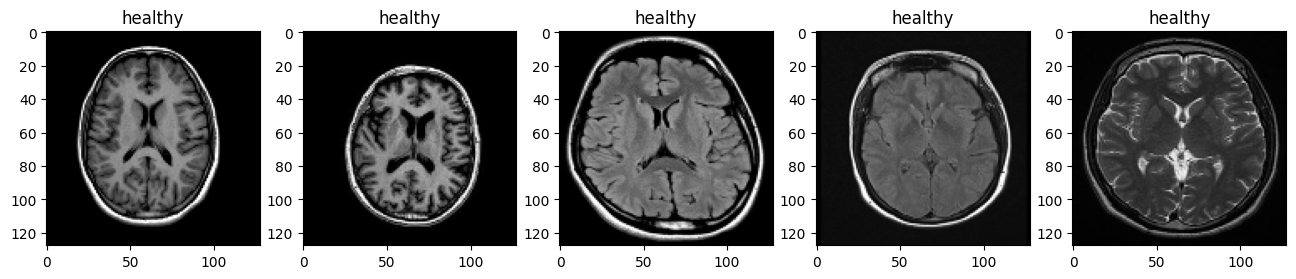

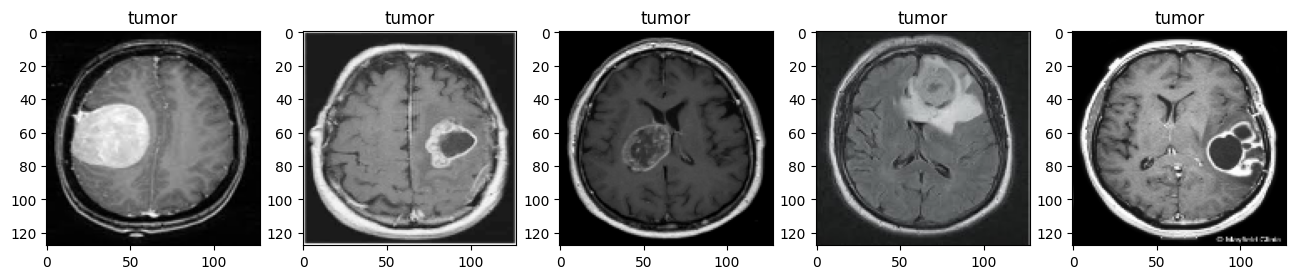

In [60]:
plot_random(healthy, tumor, num=5)

#Data Preprocessing

In [61]:
from sklearn.model_selection import train_test_split, KFold
from skimage.segmentation import slic
from skimage.filters import gaussian

In [62]:
# Create labels
tumor_labels = np.ones(len(tumor))
healthy_labels = np.zeros(len(healthy))

# Combine the data and labels
X = np.concatenate((tumor, healthy), axis=0)
y = np.concatenate((tumor_labels, healthy_labels), axis=0)

# Normalize the data
X = X / 255.0

In [63]:
# Apply superpixeling and smoothing techniques
def preprocess_image(image):
    segments = slic(image, n_segments=100, compactness=20, sigma=1)
    smooth_image = gaussian(image, sigma=1, multichannel=True)
    return smooth_image

X_preprocessed = np.array([preprocess_image(img) for img in X])

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_preprocessed):
    X_train, X_test = X_preprocessed[train_index], X_preprocessed[test_index]
    y_train, y_test = y[train_index], y[test_index]

<ipython-input-63-01664a332b68>:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  smooth_image = gaussian(image, sigma=1, multichannel=True)


In [64]:
# Count the number of images in the training and test sets
num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]

print(f'Number of training images: {num_train_images}')
print(f'Number of testing images: {num_test_images}')

Number of training images: 137
Number of testing images: 34


#Design a U-Net Model

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout

In [66]:
def unet_model_for_classification(input_shape, num_classes, dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Classification head
    f = Flatten()(c7)
    outputs = Dense(num_classes, activation='softmax')(f)

    model = Model(inputs, outputs)
    return model

# The 'categories' has been defined and it contains the class labels
input_shape = (128, 128, 3)
num_classes = len(categories)
dropout_rate = 0.5  # Hyperparameter

# Create the model
model = unet_model_for_classification(input_shape, num_classes, dropout_rate)

In [67]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the Model

In [68]:
# Hyperparameters
batch_size = 16
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 16s 762ms/step - loss: 0.6679 - accuracy: 0.5620 - val_loss: 0.6669 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - 1s 97ms/step - loss: 0.5871 - accuracy: 0.6861 - val_loss: 0.6307 - val_accuracy: 0.8235
Epoch 3/50
9/9 [==============================] - 1s 97ms/step - loss: 0.5950 - accuracy: 0.6934 - val_loss: 0.6473 - val_accuracy: 0.6765
Epoch 4/50
9/9 [==============================] - 1s 98ms/step - loss: 0.5674 - accuracy: 0.7153 - val_loss: 0.6305 - val_accuracy: 0.7059
Epoch 5/50
9/9 [==============================] - 1s 100ms/step - loss: 0.5323 - accuracy: 0.6861 - val_loss: 0.6108 - val_accuracy: 0.7059
Epoch 6/50
9/9 [==============================] - 1s 99ms/step - loss: 0.5160 - accuracy: 0.7518 - val_loss: 0.6033 - val_accuracy: 0.6765
Epoch 7/50
9/9 [==============================] - 1s 97ms/step - loss: 0.4861 - accuracy: 0.7518 - val_loss: 0.5956 - val_accuracy: 0.7059
Epoch 8/50
9/9 [========

#Evaluate the Model

In [69]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 12ms/step - loss: 3.7904 - accuracy: 0.8235
Test Loss: 3.790390968322754
Test Accuracy: 0.8235294222831726


#Visualize the Training History

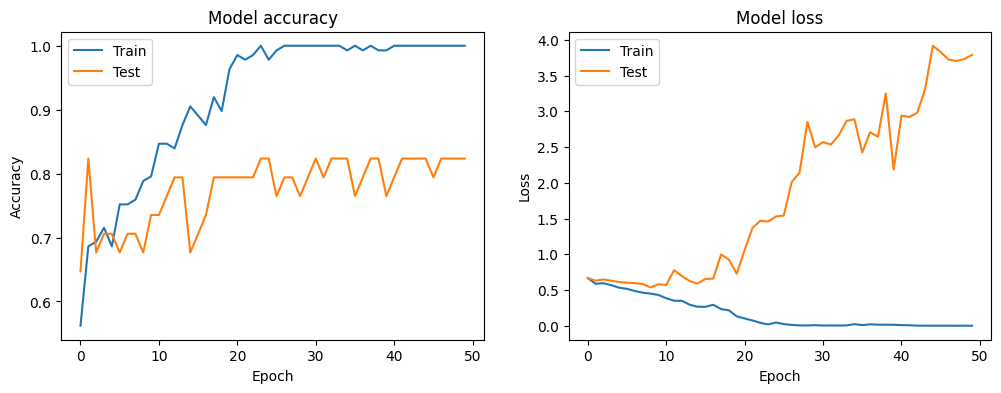

In [70]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [72]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 48ms/step


<Figure size 800x600 with 0 Axes>

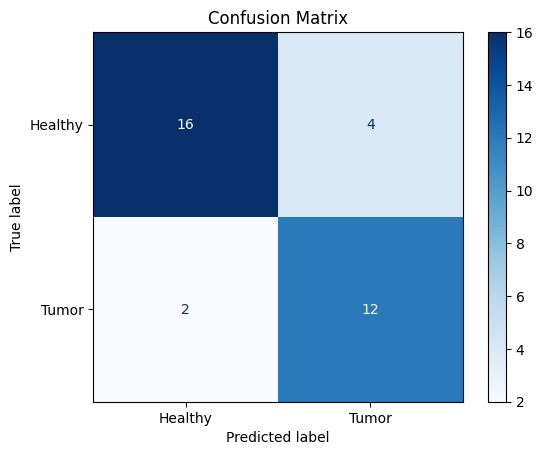

In [73]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()